### Get Christian's data

In [1]:
import glob
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
SM_SIZE = 10
MD_SIZE = 14
LG_SIZE = 16

plt.rc('font', size = MD_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = LG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize = MD_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = MD_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize = SM_SIZE)    # legend fontsize
plt.rc('figure', titlesize = LG_SIZE)   # fontsize of the figure title

In [3]:
A_100K_dir = '/blue/adamginsburg/abulatek/brick/dasar/henkel_methanol_A_100K/'
A_100K_files = glob.glob(f'{A_100K_dir}/*')

In [4]:
def nonblank_lines(f):
    for l in f:
        line = l.rstrip()
        if line:
            yield line

In [5]:
tbl_rows = []

temp_K = 100
for fn in A_100K_files:
    # Access physical parameters
    with open(fn) as f:
        i = 0
        for line in nonblank_lines(f):
            if i == 0:
                i += 1
                continue
            elif i == 1:
                params = line
                i += 1
            else:
                break
    dens = float(params.split('n(H_2)=')[1].split('(cm-3)')[0])
    # print(f'{dens:.0e}')
    coldens = float(params.split('N(CH3OH)=')[1].split('(cm-2)')[0])
    # print(f'{coldens:.0e}')
    
    # Access data
    data = ascii.read(fn, data_start = 4, header_start = 3, names = ['Ji', 'Ki', 'Vi', 'Jf', 'Kf', 'Vf', 'freq (GHz)', 'Tex(K)', 'tau', 'Tb(K)']) 
    dasar_ln = np.argmax((data['Ji'] == 3) & (data['Ki'] == 1) & (data['Jf'] == 4) & (data['Kf'] == 0))
    tex = data[dasar_ln]['Tex(K)']
    tau = data[dasar_ln]['tau']
    tb = data[dasar_ln]['Tb(K)']
    
    tbl_rows.append([dens, coldens, tex, tau, tb])
christian_tbl = Table(rows=tbl_rows, names=('dens', 'coldens', 'tex', 'tau', 'tb'))

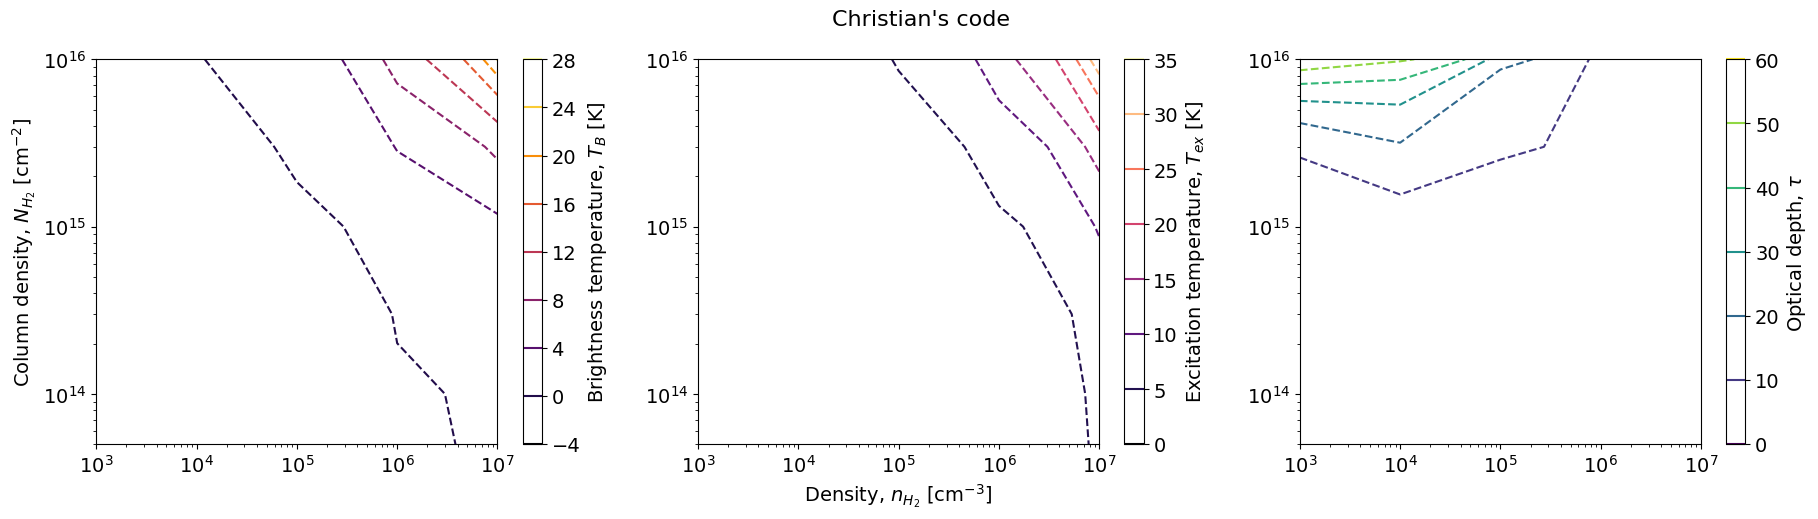

In [6]:
christian_dens, christian_dens_ids = np.unique(christian_tbl['dens'], return_inverse=True)
christian_coldens, christian_coldens_ids = np.unique(christian_tbl['coldens'], return_inverse=True)
christian_dens_grid, christian_coldens_grid = np.meshgrid(christian_dens, christian_coldens)

christian_tb_grid = np.full(christian_dens_grid.shape, np.nan)
christian_tb_grid[christian_coldens_ids, christian_dens_ids] = christian_tbl['tb']
christian_tex_grid = np.full(christian_dens_grid.shape, np.nan)
christian_tex_grid[christian_coldens_ids, christian_dens_ids] = christian_tbl['tex']
christian_tau_grid = np.full(christian_dens_grid.shape, np.nan)
christian_tau_grid[christian_coldens_ids, christian_dens_ids] = christian_tbl['tau']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (22, 5))

cp1 = ax1.contour(christian_dens_grid, christian_coldens_grid, christian_tb_grid, levels = 6, linestyles = '--', cmap = 'inferno', alpha = 1)
ax1.set_ylabel("Column density, $N_{H_2}$ [cm$^{-2}$]")
plt.colorbar(cp1, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")

cp2 = ax2.contour(christian_dens_grid, christian_coldens_grid, christian_tex_grid, levels = 6, linestyles = '--', cmap = 'magma', alpha = 1)
ax2.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
plt.colorbar(cp2, ax = ax2, label = r"Excitation temperature, $T_{ex}$ [K]")

cp3 = ax3.contour(christian_dens_grid, christian_coldens_grid, christian_tau_grid, levels = 6, linestyles = '--', cmap = 'viridis', alpha = 1)
plt.colorbar(cp3, ax = ax3, label = r"Optical depth, $\tau$")

for ax in [ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.suptitle("Christian's code")

plt.show()

### Run RADEX for the same situation (100 K)

In [7]:
import pyradex
import os
os.environ['RADEX_DATAPATH'] = '/orange/adamginsburg/repos/pyradex/lamda/'
import matplotlib.pyplot as plt
from astroquery.lamda import Lamda
# import dask
# dask.config.set(scheduler = 'threads', num_workers = 8)
# from dask.diagnostics import ProgressBar
# ProgressBar().register()

In [8]:
ls /orange/adamginsburg/repos/pyradex/lamda/

ch3oh_a.dat  co.dat  nacl.dat  ph2co-h2.dat  sio-h2.dat


In [9]:
# Get methanol A species results for given column, density, and temperature
set_column = 1e14
set_density = 1e5
set_temp = 50
rr = pyradex.Radex(species='ch3oh_a', column=set_column, density=set_density, temperature=set_temp)
tbl = rr()

/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:542: UserWarning: Using a default ortho-to-para ratio (which will only affect species for which independent ortho & para collision rates are given)
  warnings.warn("Using a default ortho-to-para ratio (which "
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:968: RuntimeWarning: invalid value encountered in true_divide
  frac_level_diff = level_diff/self.level_population
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/pyradex-0.4.2.dev0-py3.9.egg/pyradex/core.py:1056: RuntimeWarning: overflow encountered in exp
  bnutex = thc*xt/(np.exp(earg)-1.0)


In [10]:
# Which line is the dasar line?
np.argmax((tbl['upperlevel'] == b'3_1   ') & (tbl['lowerlevel'] == b'4_0   '))

62

In [11]:
tbl[62]

Tex,tau,frequency,upperstateenergy,upperlevel,lowerlevel,upperlevelpop,lowerlevelpop,brightness,T_B
K,,GHz,K,,,,,erg / (cm2 Hz s sr),K
float64,float64,float64,float64,bytes6,bytes6,float64,float64,float64,float64
1.3046936795972943,0.3458920073168159,107.013831,28.3,3_1,4_0,0.0027329811516297064,0.17991856934978337,-8.458739164652115e-16,-0.24041077989339263


In [12]:
radex_dens = np.geomspace(np.min(christian_tbl['dens']), np.max(christian_tbl['dens']), 20)
radex_coldens = np.geomspace(1e13, np.max(christian_tbl['coldens']), 20)
rslts = [[rr(density = {'H2':dens}, column = coldens, temperature = 100)[62]['Tex', 'tau', 'T_B'] for dens in radex_dens] for coldens in radex_coldens]

In [13]:
radex_tex = [[l['Tex'] for l in r] for r in rslts] # I tried this and it was wrong: [l['Tex'] for r in rslts for l in r]
radex_tau = [[l['tau'] for l in r] for r in rslts]
radex_T_B = [[l['T_B'] for l in r] for r in rslts]

In [14]:
print("helloworld")

helloworld


-0.819132482178787 is the minimum, it doesn't actually go down to -1


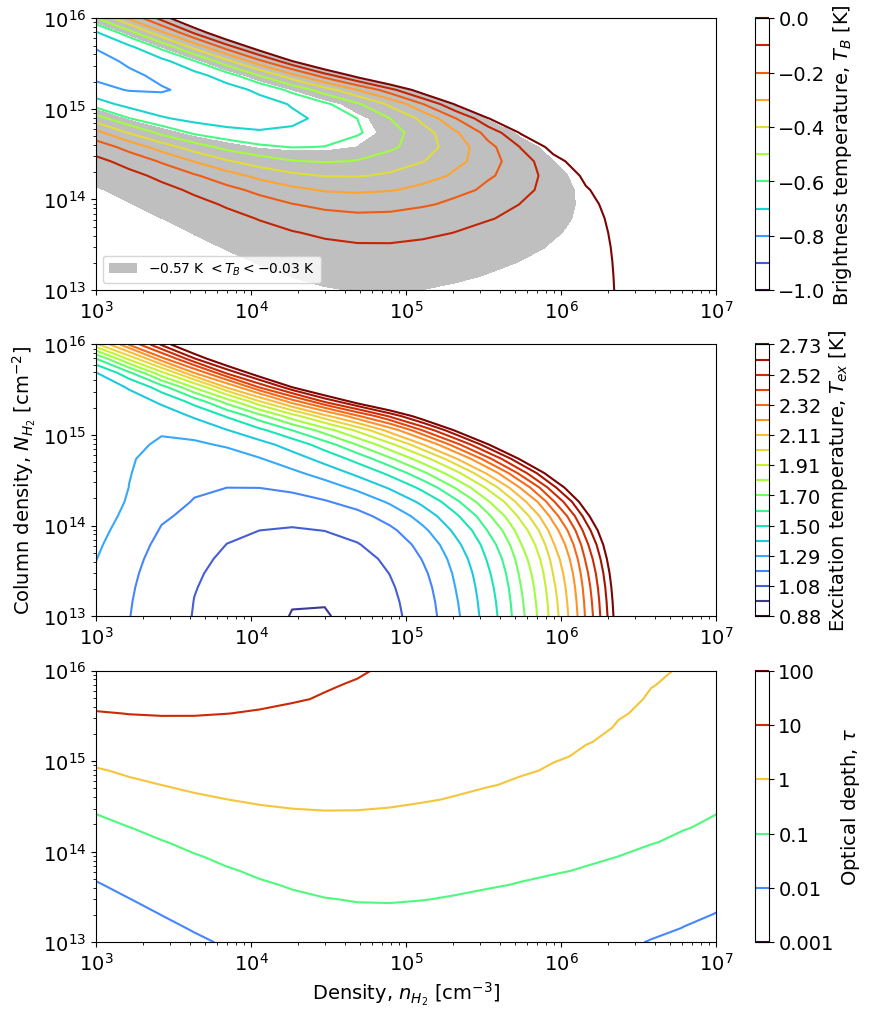

In [36]:
import matplotlib.colors as colors

radex_dens, radex_dens_ids = np.unique(radex_dens, return_inverse=True) # This line doesn't work because I need to know which 
                                                                        # Tex map to which dens and coldens
radex_coldens, radex_coldens_ids = np.unique(radex_coldens, return_inverse=True)
radex_dens_grid, radex_coldens_grid = np.meshgrid(radex_dens, radex_coldens)

# radex_tb_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tb_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_T_B)
# radex_tex_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tex_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_tex)
# radex_tau_grid = np.full(radex_dens_grid.shape, np.nan)
# radex_tau_grid[radex_coldens_ids, radex_dens_ids] = np.array(radex_tau)

lvl_set = 11 # odd, want smth at middle

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 12)) #24, 8

print(np.min(radex_T_B),"is the minimum, it doesn't actually go down to -1") # -0.819132482178787

cp1 = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, 
                  levels = np.linspace(-1, 0, lvl_set), 
                  cmap = 'turbo', alpha = 1) #inferno
plt.colorbar(cp1, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")

# Shading where T_B goes below 0, and where it goes below our data value (-0.03 K is placeholder for now)
darkest_spectrum = -0.57
least_dark_spectrum_detectable = -0.03 # This is negative 1 sigma
# radex_T_B_arr = np.array(radex_T_B)
# [c, d] = np.where((radex_T_B_arr > darkest_spectrum) & (radex_T_B_arr < least_dark_spectrum_detectable))

# radex_T_B_arr_hatch = np.zeros(radex_T_B_arr.shape)
# radex_T_B_arr_hatch[c, d] = 1
cs1 = ax1.contourf(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = [darkest_spectrum, least_dark_spectrum_detectable],
                   alpha = 0.5, colors = ['grey'])
artists1, labels1 = cs1.legend_elements()
ax1.legend(handles = [artists1[0]], labels = [f'${darkest_spectrum}$ K $< T_B < {least_dark_spectrum_detectable} $ K'], loc="lower left")

cp2 = ax2.contour(radex_dens_grid, radex_coldens_grid, radex_tex, 
                  levels = np.around(np.linspace(np.min(radex_tex)*0.9, 2.73, 19), decimals = 2), 
                  cmap = 'turbo', alpha = 1) #magma
ax2.set_ylabel("Column density, $N_{H_2}$ [cm$^{-2}$]")
plt.colorbar(cp2, ax = ax2, label = r"Excitation temperature, $T_{ex}$ [K]")

# Shading where T_ex goes below 2
# radex_tex_arr = np.array(radex_tex)
# [m, n] = np.where(radex_tex_arr < 2.0)

# radex_tex_arr_hatch = np.zeros(radex_tex_arr.shape)
# radex_tex_arr_hatch[m, n] = 1
# cs2 = ax2.contourf(radex_dens_grid, radex_coldens_grid, radex_tex, levels = [0, 2], alpha = 0.5, colors = ['grey'])
# artists2, labels2 = cs2.legend_elements()
# ax2.legend(handles = [artists2[0]], labels = ['$T_{ex} < 2$ K'], loc="lower left")

cp3 = ax3.contour(radex_dens_grid, radex_coldens_grid, radex_tau, levels = lvl_set, cmap = 'turbo', alpha = 1, #viridis
                  norm=colors.LogNorm(vmin=np.array(radex_tau).min(), vmax=np.array(radex_tau).max()))
ax3.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
cb3 = plt.colorbar(cp3, ax = ax3, extend = 'max', label = r"Optical depth, $\tau$")
cb3.set_ticklabels([f'{x:0.1g}' if x % 1 > 0 else int(x) for x in cb3.get_ticks()])

for ax in [ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.set_yscale('log')

# plt.suptitle("RADEX")

plt.savefig('632e0742965a6e88270d73d7/figures/pyradex_results.pdf', bbox_inches = 'tight')
plt.savefig('632e0742965a6e88270d73d7/figures/pyradex_results.png', dpi = 200, bbox_inches = 'tight')
plt.show()

### Overplot Christian's results and RADEX results (appendix figure)

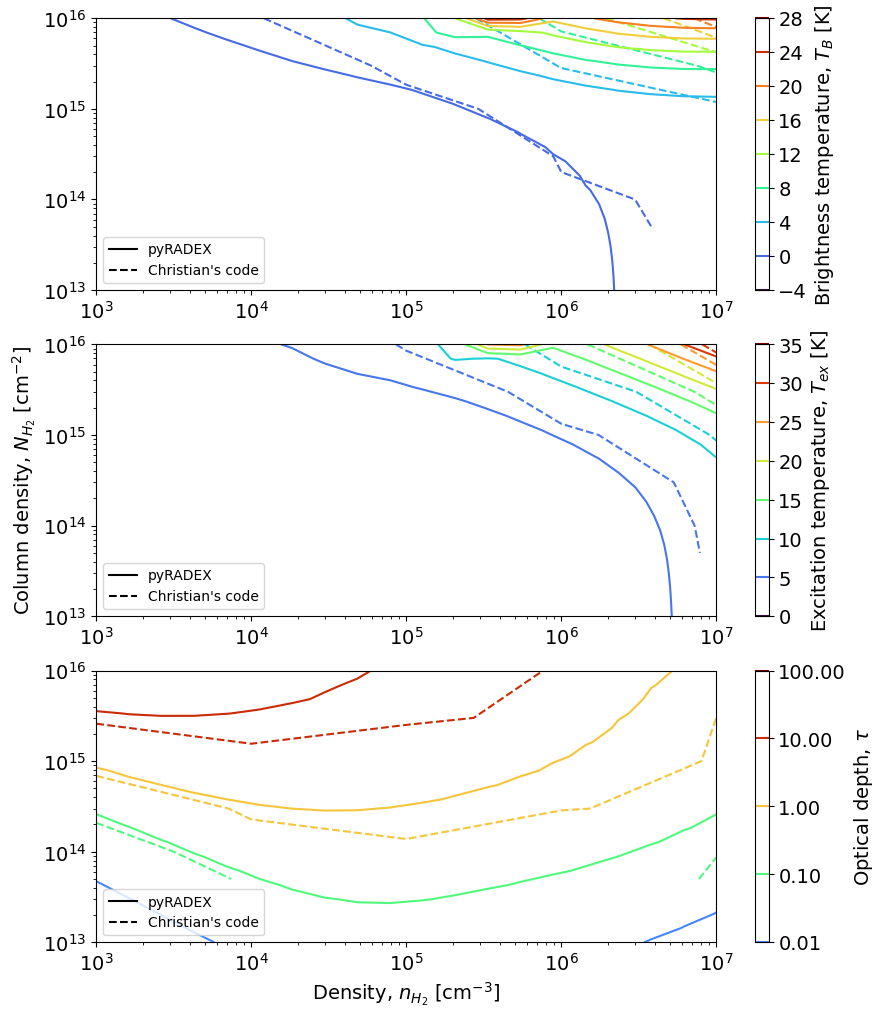

In [16]:
from matplotlib.lines import Line2D

lvl_set = 6

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 12)) #24, 8

# Brightness temperature
cp1a = ax1.contour(christian_dens_grid, christian_coldens_grid, christian_tb_grid, levels = lvl_set, 
                   linestyles = '--', cmap = 'turbo')
cp1b = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = lvl_set, cmap = 'turbo', alpha = 1) #inferno
plt.colorbar(cp1a, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")
# plt.colorbar(cp1b, ax = ax1)
code_artists = [Line2D([0], [0], color='k'), Line2D([0], [0], color='k', linestyle='--')]
code_labels = ["pyRADEX", "Christian's code"]

# # Shading where T_B goes below 0, and where it goes below our data value (-0.1 K is placeholder for now)
# christian_tb_grid_arr = np.array(christian_tb_grid)
# [e, f] = np.where((christian_tb_grid_arr > darkest_spectrum) & (christian_tb_grid_arr < least_dark_spectrum_detectable))
# christian_tb_grid_arr_hatch = np.zeros(christian_tb_grid_arr.shape)
# christian_tb_grid_arr_hatch[e, f] = 1

# cs1a = ax1.contourf(radex_dens_grid, radex_coldens_grid, radex_T_B_arr_hatch, levels = 1, alpha = 0.5, colors = ['w','r']) # hatches=['','//'],
# artists1a, labels1a = cs1a.legend_elements()
# cs1b = ax1.contourf(christian_dens_grid, christian_coldens_grid, christian_tb_grid_arr_hatch, levels = 1, alpha = 0.5, colors = ['w','b']) # hatches=['','//'],
# artists1b, labels1b = cs1b.legend_elements()

ax1.legend(handles = code_artists,#+[artists1a[1], artists1b[1]], 
           labels = code_labels,#+[f'${darkest_spectrum}$ K $< T_B < {least_dark_spectrum_detectable} $ K (pyRADEX)', f"${darkest_spectrum}$ K $< T_B < {least_dark_spectrum_detectable} $ K (Christian's code)"], 
           loc="lower left")

# Excitation temperature
cp2a = ax2.contour(christian_dens_grid, christian_coldens_grid, christian_tex_grid, levels = lvl_set, 
                   linestyles = '--', cmap = 'turbo')
cp2b = ax2.contour(radex_dens_grid, radex_coldens_grid, radex_tex, levels = lvl_set, cmap = 'turbo', alpha = 1) #magma
plt.colorbar(cp2a, ax = ax2, label = r"Excitation temperature, $T_{ex}$ [K]")
ax2.set_ylabel("Column density, $N_{H_2}$ [cm$^{-2}$]")
# plt.colorbar(cp2b, ax = ax2)

# # Shading where T_ex goes below 2
# christian_tex_grid_arr = np.array(christian_tex_grid)
# [o, p] = np.where(christian_tex_grid_arr < 2.0)

# christian_tex_grid_arr_hatch = np.zeros(christian_tex_grid_arr.shape)
# christian_tex_grid_arr_hatch[o, p] = 1

# cs2a = ax2.contourf(radex_dens_grid, radex_coldens_grid, radex_tex_arr_hatch, levels = 1, alpha = 0.5, colors = ['w','r'])
# artists2a, labels2a = cs2a.legend_elements()
# cs2b = ax2.contourf(christian_dens_grid, christian_coldens_grid, christian_tex_grid_arr_hatch, levels = 1, alpha = 0.5, colors = ['w','b'])
# artists2b, labels2b = cs2b.legend_elements()

ax2.legend(handles = code_artists,#+[artists2a[1], artists2b[1]],
           labels = code_labels,#+['$T_{ex} < 2$ K (pyRADEX)', "$T_{ex} < 2$ K (Christian's code)"],
           loc = "lower left")

# Optical depth
cp3a = ax3.contour(christian_dens_grid, christian_coldens_grid, christian_tau_grid, levels = lvl_set, 
                   linestyles = '--', cmap = 'turbo', 
                   norm=colors.LogNorm(vmin=np.array(radex_tau).min(), vmax=np.array(radex_tau).max()))
cp3b = ax3.contour(radex_dens_grid, radex_coldens_grid, radex_tau, levels = lvl_set, cmap = 'turbo', alpha = 1,
                   norm=colors.LogNorm(vmin=np.array(radex_tau).min(), vmax=np.array(radex_tau).max())) #viridis
ax3.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
plt.colorbar(cp3a, ax = ax3, label = r"Optical depth, $\tau$")
# plt.colorbar(cp3b, ax = ax3)
ax3.legend(handles = code_artists, labels = code_labels, loc="lower left")

for ax in [ax1, ax2, ax3]:
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.savefig('632e0742965a6e88270d73d7/figures/christian_pyradex_comparison.pdf', bbox_inches = 'tight')
plt.savefig('632e0742965a6e88270d73d7/figures/christian_pyradex_comparison.png', dpi = 200, bbox_inches = 'tight')
plt.show()

### For symposium 2022 talk (remove the tau, for brevity's sake)

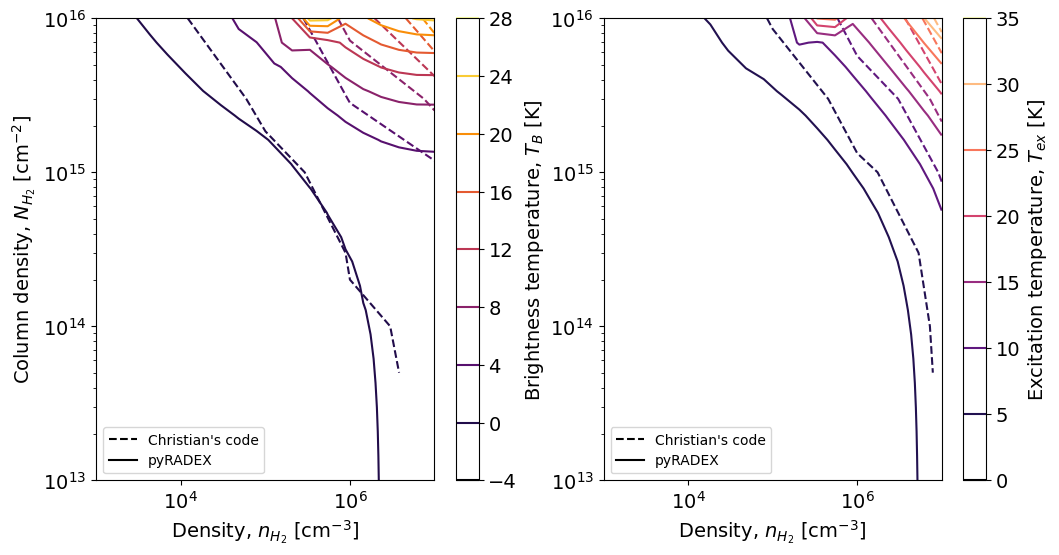

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

cp1a = ax1.contour(christian_dens_grid, christian_coldens_grid, christian_tb_grid, levels = 6, 
                   linestyles = '--', cmap = 'inferno')
cp1b = ax1.contour(radex_dens_grid, radex_coldens_grid, radex_T_B, levels = 6, cmap = 'inferno', alpha = 1)
ax1.set_ylabel("Column density, $N_{H_2}$ [cm$^{-2}$]")
ax1.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
plt.colorbar(cp1a, ax = ax1, label = r"Brightness temperature, $T_B$ [K]")
# plt.colorbar(cp1b, ax = ax1)
legend_elements = [Line2D([0], [0], color='k', linestyle='--', label="Christian's code"),
                   Line2D([0], [0], color='k', label="pyRADEX")]
ax1.legend(handles = legend_elements, loc="lower left")

cp2a = ax2.contour(christian_dens_grid, christian_coldens_grid, christian_tex_grid, levels = 6, 
                   linestyles = '--', cmap = 'magma')
cp2b = ax2.contour(radex_dens_grid, radex_coldens_grid, radex_tex, levels = 6, cmap = 'magma', alpha = 1)
ax2.set_xlabel("Density, $n_{H_2}$ [cm$^{-3}$]")
plt.colorbar(cp2a, ax = ax2, label = r"Excitation temperature, $T_{ex}$ [K]")
# plt.colorbar(cp2b, ax = ax2)
ax2.legend(handles = legend_elements, loc="lower left")

for ax in [ax1, ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.savefig('632e0742965a6e88270d73d7/figures/christian_pyradex_comparison_notau.pdf', bbox_inches = 'tight')
plt.savefig('632e0742965a6e88270d73d7/figures/christian_pyradex_comparison_notau.png', dpi = 200, bbox_inches = 'tight')
plt.show()

### Vary the CMB temperature

In [ ]:
# Calculate RADEX results at z = 1
rslts = [[rr(density = {'H2':dens}, column = coldens, temperature = 100)[62]['Tex', 'tau', 'T_B'] 
          for dens in radex_dens] for coldens in radex_coldens]